### Model performance comparison analysis
#### Since this analysis was performed based on the demo setup, the sample size and training epoch size are limited. 
#### Therefore, the results of this analysis are very different from those of the author's research.

In [1]:
import os
import sys
sys.path.insert(0,'..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import statsmodels.api as sm
import seaborn as sns
from numpy import mean as npMean
import re
from SRC.Module.MetricsGroup import DoAggMetric, DoSimEval
NumGene_CL = 100


### Metric table load

In [2]:
ModelList = ['RCFR', 'RCFR_AC_W:1']

DIR = './EvalResults/'

MetricTableList = os.listdir(DIR)
MetricTableList = [i for i in MetricTableList if 'AggMetricRank' in i and str(NumGene_CL) in i ]

PosMetTabDic = {i.replace('AggMetricRank_', '').replace('_Filt'+str(NumGene_CL)+'.csv', '') : pd.read_csv(DIR+i) for i in MetricTableList if 'Pos' in i} 
NegMetTabDic = {i.replace('AggMetricRank_', '').replace('_Filt'+str(NumGene_CL)+'.csv', '') : pd.read_csv(DIR+i) for i in MetricTableList if 'Neg' in i} 

for i in PosMetTabDic:
    PosMetTabDic[i]['Model'] = i.replace('_Pos', '')
    
for i in NegMetTabDic:
    NegMetTabDic[i]['Model'] = i.replace('_Neg', '')


### Metric table merge

In [3]:
PosMetricTotal = pd.concat(PosMetTabDic).reset_index(drop=True)
NegMetricTotal = pd.concat(NegMetTabDic).reset_index(drop=True)

PosMetricTotal['Model'] = PosMetricTotal['Model'].replace({'_NoCL_W1':'$_{NoCL}$', '_NoSIM_W1':'$_{NoSim}$', '_NoGROM':'$_{NoGROM}$' ,'_W1':'$_{W:1}$', '_W2':'$_{W:2}$', '_W3':'$_{W:3}$', }, regex=True)
NegMetricTotal['Model'] = NegMetricTotal['Model'].replace({'_NoCL_W1':'$_{NoCL}$', '_NoSIM_W1':'$_{NoSim}$', '_NoGROM':'$_{NoGROM}$' ,'_W1':'$_{W:1}$', '_W2':'$_{W:2}$', '_W3':'$_{W:3}$', }, regex=True)


NegMetricTotal.columns = [i.replace('Neg','') for i in NegMetricTotal.columns.tolist()]
PosMetricTotal.columns = [i.replace('Pos','') for i in PosMetricTotal.columns.tolist()]

NegMetricTotal['Sign'] = 'Negative'
PosMetricTotal['Sign'] = 'Positive'
Agg_MetricTotal = pd.concat([PosMetricTotal, NegMetricTotal], axis=0)

## Performance plot for both Patient and Gene-side  

In [4]:
def PerformancebyModel (TestColName, TestLabelName, MetricTotal, ModelList, TitleList, Leg=True):
    plt.figure(figsize=(20,10))

    
    #sns.set_theme(style="darkgrid")
    
    for numi, i in enumerate(TestColName):
        plt.subplot(2,2,numi+1)
        #sns.violinplot(x='Model' ,y=i, scale="width", data=MetricTotal, cut=0,  order=ModelList)
        #sns.pointplot(x ='Model', y=i, data=MetricTotal, estimator=npMean, color='lightseagreen', order=ModelList,linestyles='-', capsize=0.1, err_style='bars',errwidth=1.5)

        if numi != 0:
            ax = sns.swarmplot(x="Model", y=i, data=MetricTotal, order=ModelList, size=5, alpha=1., linewidth=1.5, edgecolor='gray', zorder=1, hue='Sign')
            sns.pointplot(x ='Model', y=i, data=MetricTotal, estimator=npMean, order=ModelList,
                          capsize=0.1, err_style='bars',errwidth=1.5, markers='D', hue='Sign', linestyles=["-", "--"], scale=1.)
            handles, labels = ax.get_legend_handles_labels()
            ax.legend_.remove()
        else:
            ax = sns.swarmplot(x="Model", y=i, data=MetricTotal, order=ModelList, size=5, alpha=1., linewidth=1.5, edgecolor='gray', zorder=1, hue='Sign')
            sns.pointplot(x ='Model', y=i, data=MetricTotal, estimator=npMean, order=ModelList,
                          capsize=0.1, err_style='bars',errwidth=1.5, markers='D', hue='Sign', linestyles=["-", "--"], scale=1.)
            handles, labels = ax.get_legend_handles_labels()
            #ax.legend(handles[:2], labels[:2],bbox_to_anchor=(1.25, 0.65), loc=0, ncol=1,  prop={'size': 14})
            
            if Leg:
                ax.legend(handles[:2], labels[:2], prop={'size': 18})
            else:
                ax.legend_.remove()
 

        plt.xticks(fontsize=18, rotation=20)
        plt.yticks(fontsize=18, rotation=10)
        plt.xlabel('', size=20, labelpad=10)
        plt.title(TitleList[numi], size=24, pad=13)
        plt.ylabel(TestLabelName[numi], size=20 )
        #plt.ylim(bottom=-0.05)
        plt.subplots_adjust(hspace=0.5,wspace=0.15)

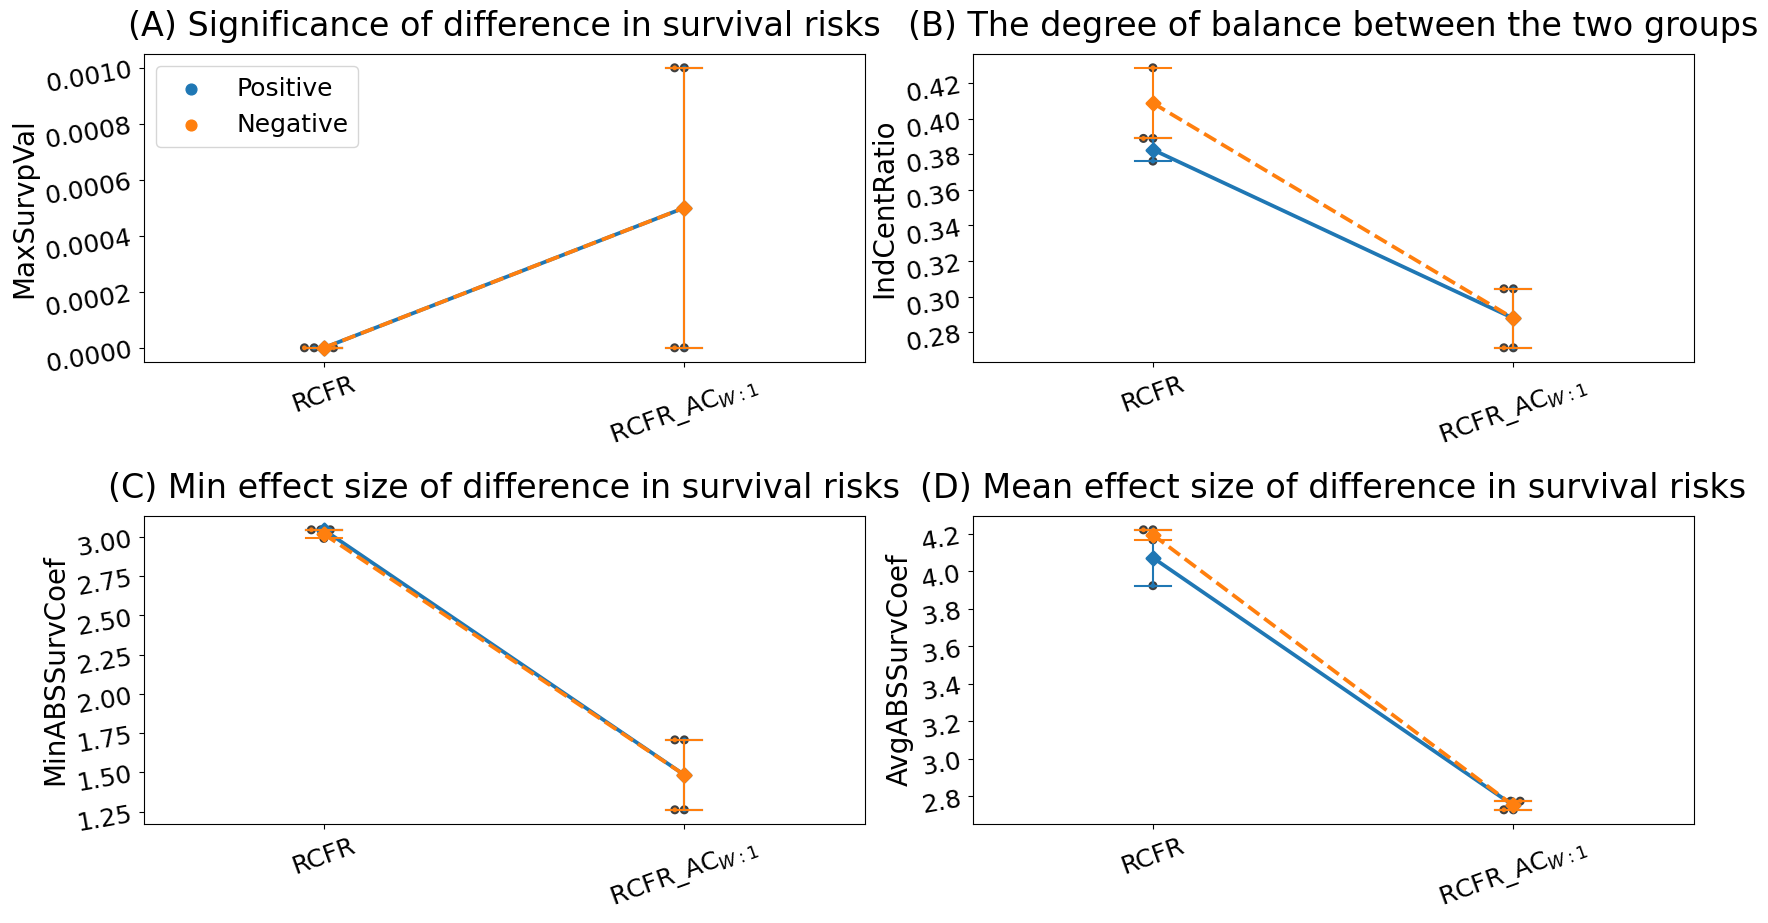

In [5]:
TestColName = ['MaxSurvpVal', 'IndCentRatio', 'MinABSSurvCoef', 'AvgABSSurvCoef']
TestLabelName = ['MaxSurvpVal', 'IndCentRatio', 'MinABSSurvCoef', 'AvgABSSurvCoef']
TitleList = ['(A) Significance of difference in survival risks',
          '(B) The degree of balance between the two groups',
          '(C) Min effect size of difference in survival risks',
          '(D) Mean effect size of difference in survival risks']

PerformancebyModel(TestColName, TestLabelName, Agg_MetricTotal, np.unique(PosMetricTotal['Model']).tolist(), TitleList, True)
plt.savefig('./Figures/PatientSide_Performance.png')


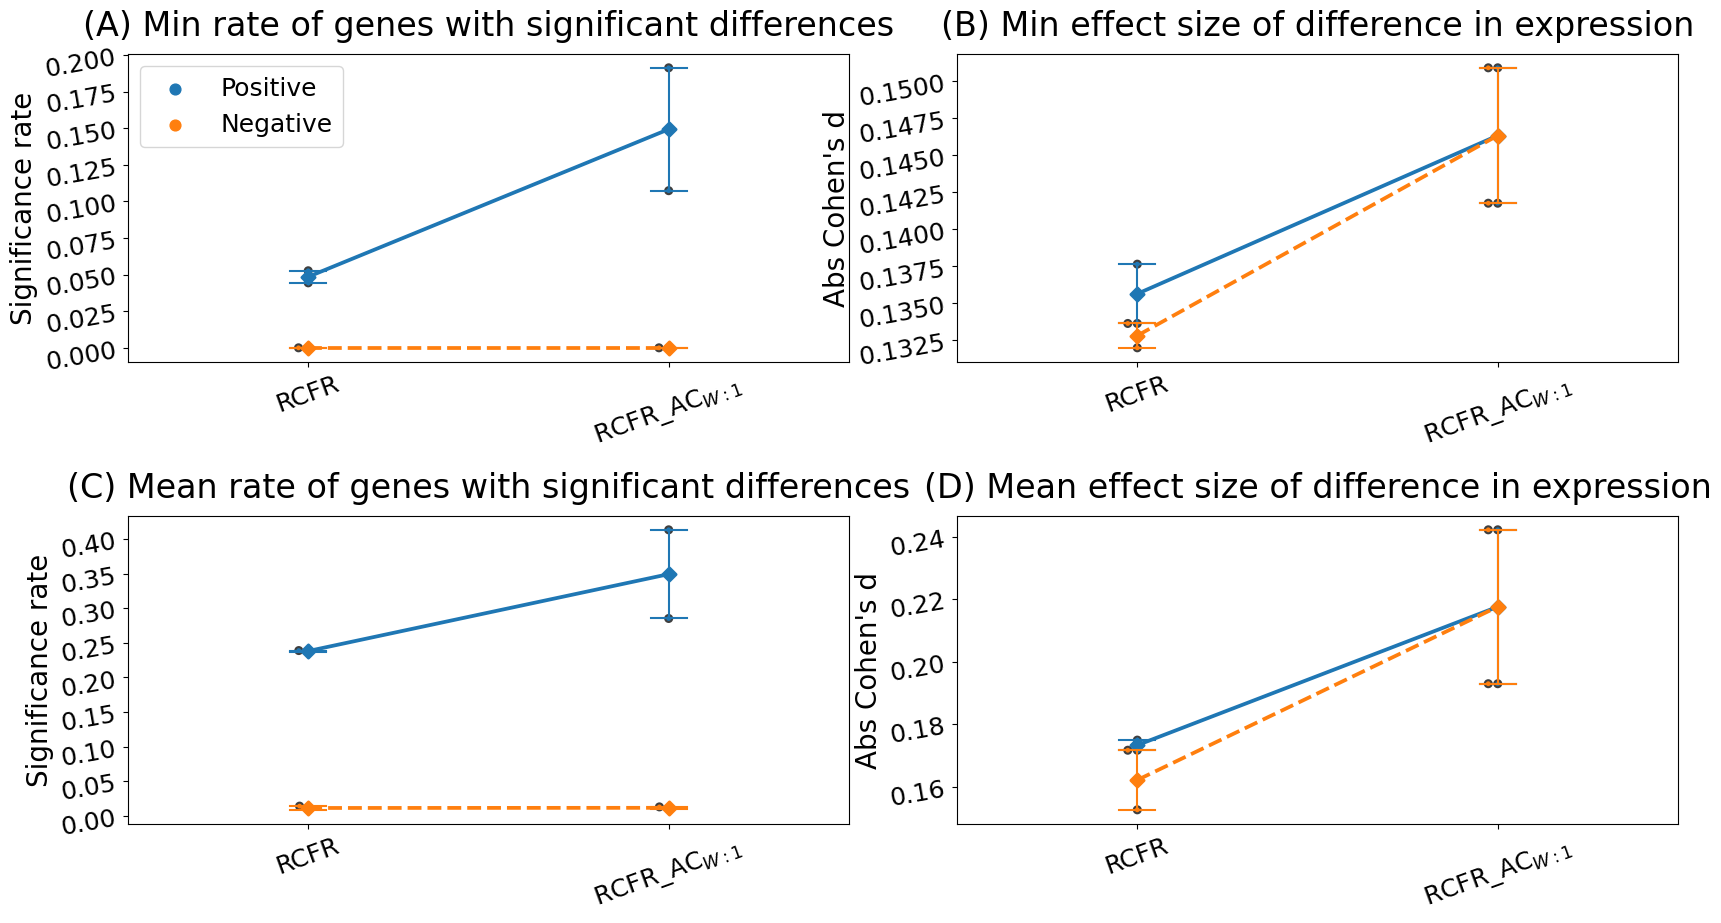

In [6]:
TestColName = ['MinSigRate', 'MinABSGeCohD','AvgSigRate', 'AvgABSGeCohD' ]
TestLabelName = ["Significance rate", "Abs Cohen's d", "Significance rate", "Abs Cohen's d"]
TitleList = ['(A) Min rate of genes with significant differences',
      '(B) Min effect size of difference in expression',
      '(C) Mean rate of genes with significant differences',
      '(D) Mean effect size of difference in expression']

PerformancebyModel(TestColName, TestLabelName, Agg_MetricTotal, np.unique(PosMetricTotal['Model']).tolist(), TitleList, True)
plt.savefig('./Figures/GeneSide_Performance.png')


## Performance table

In [7]:
Cols = ['MaxSurvpVal', 'IndCentRatio', 'MinABSSurvCoef', 'AvgABSSurvCoef' , 'MinSigRate', 'AvgSigRate','MinABSGeCohD', 'AvgABSGeCohD']
RateCols = ['IndCentRatio','MinSigRate', 'AvgSigRate']
PerformanceTable = Agg_MetricTotal.groupby(['Sign','Model']).mean()[Cols]
PerformanceTable[RateCols] = PerformanceTable[RateCols]*100
PerformanceTable = np.round(PerformanceTable, 3)
PerformanceTable[RateCols] = PerformanceTable[RateCols].astype('str')+ '%'

PerformanceTable['MaxSurvpVal'] = PerformanceTable['MaxSurvpVal'].astype('str')
PerformanceTable['MaxSurvpVal'] = PerformanceTable['MaxSurvpVal'].replace({'0.0':'p<0.001'})
PerformanceTable.to_csv('./EvalResults/PerformanceTable.csv')

### Data load for best model selection 

In [8]:
DIR = './EvalResults/'
MetricTableList = os.listdir(DIR)
MetricTableList = [i for i in MetricTableList if 'AggMetricRank' in i and str(NumGene_CL) in i ]


PosMetTabDic = {i.replace('AggMetricRank_', '').replace('_Filt'+str(NumGene_CL)+'.csv', '') : pd.read_csv(DIR+i) for i in MetricTableList if 'Pos' in i} 
NegMetTabDic = {i.replace('AggMetricRank_', '').replace('_Filt'+str(NumGene_CL)+'.csv', '') : pd.read_csv(DIR+i) for i in MetricTableList if 'Neg' in i} 

PosMetricTotal = pd.concat(PosMetTabDic).reset_index(drop=True)
NegMetricTotal = pd.concat(NegMetTabDic).reset_index(drop=True)



### Model level filtering

In [9]:
SelectiveKeyword = 'M06'
ModelFilter = [SelectiveKeyword in i.Model for i in NegMetricTotal.iloc]
NegMetricSelected = NegMetricTotal[ModelFilter]

ModelFilter = [SelectiveKeyword in i.Model for i in PosMetricTotal.iloc]
PosMetricSelected = PosMetricTotal[ModelFilter]


### Best model selection

In [10]:
def Aggregation(MetricTable,AggMetricList):
    
    AggMetricRank = DoAggMetric(AggMetricList, MetricTable[['Model']+AggMetricList]).sort_values('Metrics')
    AggMetricRank = pd.merge(AggMetricRank, MetricTable[['Model','MaxSurvpVal']], on='Model', how='left')
    BestModel = AggMetricRank.sort_values('Metrics').iloc[-1]

    return AggMetricRank, BestModel

In [11]:
pCutoff = 0.005
ExcRate = 0.2
NmodEahG = 1

NegMetricList = ['IndCentRatio', 'MinABSSurvCoef', 'AvgABSSurvCoef',  'MinNegSigRate', 'AvgNegSigRate', 'MinABSGeCohD', 'AvgABSGeCohD']
PosMetricList = ['IndCentRatio', 'MinABSSurvCoef', 'AvgABSSurvCoef', 'MinPosSigRate', 'AvgPosSigRate', 'MinABSGeCohD', 'AvgABSGeCohD']


NegAggMetricRank, NegBestModel =  Aggregation(NegMetricSelected, NegMetricList)
PosAggMetricRank, PosBestModel =  Aggregation(PosMetricSelected, PosMetricList)

NegBestModel, PosBestModel

(Model                 M06_RCFR_AC_W1_S2_Epo17.hdf5
 IndCentRatio                              0.304348
 MinABSSurvCoef                            1.261258
 AvgABSSurvCoef                            2.773076
 MinNegSigRate                                  0.0
 AvgNegSigRate                             0.012712
 MinABSGeCohD                              0.141752
 AvgABSGeCohD                              0.192964
 NormIndCentRatio                               1.0
 NormMinABSSurvCoef                             0.0
 NormAvgABSSurvCoef                             1.0
 NormMinNegSigRate                              0.0
 NormAvgNegSigRate                              1.0
 NormMinABSGeCohD                               0.0
 NormAvgABSGeCohD                               0.0
 Metrics                                        3.0
 MaxSurvpVal                                  0.001
 Name: 1, dtype: object,
 Model                 M06_RCFR_AC_W1_S1_Epo20.hdf5
 IndCentRatio                          

### Performance difference by sign over epochs

In [12]:
DIR = './EvalResults/'
MetricTableList = os.listdir(DIR)
MetricTableList = [i for i in MetricTableList if 'MetricTable' in i and str(NumGene_CL) in i ]
MetTabDic = {i.replace('MetricTable_', '').replace('Filt'+str(NumGene_CL)+'.csv', '') : pd.read_csv(DIR+i) for i in MetricTableList} 


for i in MetTabDic:
    MetTabDic[i]['Model'] = i
    
MetTabDic = pd.concat(MetTabDic).reset_index(drop=True)


In [13]:
def ToLongSigRate (Data):
    
    LongMetTabDic =  pd.melt(Data, id_vars=['Model','EpNum'], value_vars=['AvgNegSigRate','AvgPosSigRate','MinNegSigRate','MinPosSigRate']).copy()
    LongMetTabDic = LongMetTabDic.rename(columns={'value':'Rate'})

    LongMetTabDic['Metric'] = 'Min'
    LongMetTabDic['Sign'] = 'Neg.'

    LongMetTabDic.loc[LongMetTabDic['variable'].str.contains('Avg'), 'Metric'] = 'Mean'
    LongMetTabDic.loc[LongMetTabDic['variable'].str.contains('Pos'), 'Sign'] = 'Pos.'
    
    return LongMetTabDic


def ToLongSurvSig (Data):
    
    LongMetTabDic =  pd.melt(Data, id_vars=['Model','EpNum'], value_vars=['MaxSurvpVal']).copy()
    LongMetTabDic['Span'] = LongMetTabDic['value'] < 0.05
    LongMetTabDic = LongMetTabDic.groupby('EpNum').mean().reset_index()
    LongMetTabDic['Span'] = LongMetTabDic['Span']==1

    
    return LongMetTabDic

ModelList = np.unique(MetTabDic['Model'])
MetTabDicSigRate = {i:ToLongSigRate(MetTabDic[MetTabDic['Model']==i]) for i in ModelList}
MetTabDicSurvSig = {i:ToLongSurvSig(MetTabDic[MetTabDic['Model']==i]) for i in ModelList}


### Visualization

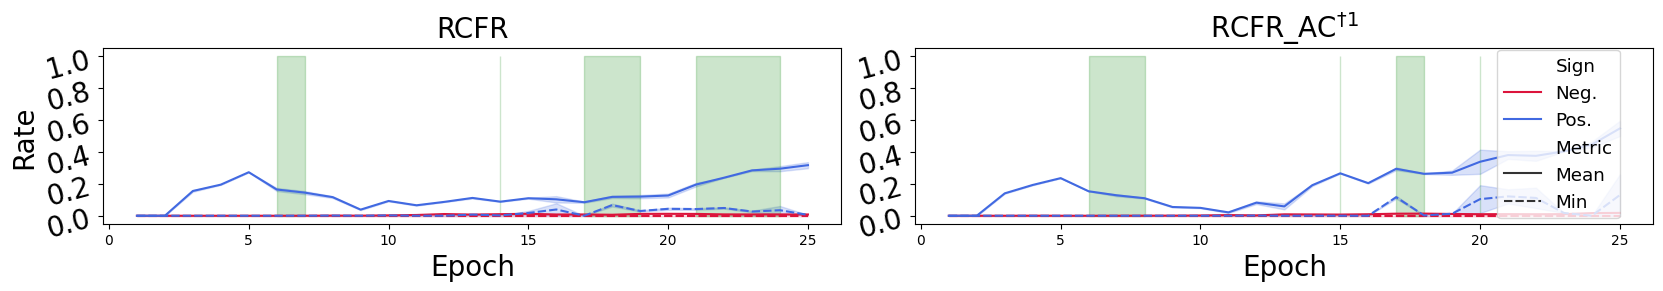

In [14]:
ModelListOrder = ['RCFR_', 'RCFR_AC_W1_']
ModelListLabel = ['RCFR', 'RCFR_AC$^{†1}$']


plt.figure(figsize=(20, 12))

for numi, i in enumerate(ModelListOrder):
    plt.subplot(4,2,numi+1)
    
    if numi != len(ModelListOrder)-1:
        sns.lineplot(x="EpNum", y="Rate", data=MetTabDicSigRate[i], hue='Sign', palette=['crimson','royalblue'], style='Metric', legend=False)
        plt.fill_between(MetTabDicSurvSig[i]['EpNum'], 0,1, where=MetTabDicSurvSig[i]['Span'], color='g', alpha=0.2)
    else:
        sns.lineplot(x="EpNum", y="Rate", data=MetTabDicSigRate[i], hue='Sign', palette=['crimson','royalblue'], style='Metric', legend=True)
        plt.fill_between(MetTabDicSurvSig[i]['EpNum'], 0,1, where=MetTabDicSurvSig[i]['Span'], color='g', alpha=0.2)
        plt.legend(bbox_to_anchor=(0.788, 0.99), loc=2, borderaxespad=0., prop={'size': 13.2}, ncol=1)    
        #plt.legend(bbox_to_anchor=(0.00, -0.3), loc=2, borderaxespad=0., prop={'size': 13}, ncol=2, title='')    
        #plt.legend(prop={'size': 13}, ncol=1)    
        
        
    if numi >= len(ModelListOrder)-2:
        plt.xlabel('Epoch', size=20)
    else:
        plt.xlabel('')
            
    if numi % 2 ==0:
        plt.ylabel('Rate', size=20 )
    else:
        plt.ylabel('')
    
    plt.title(ModelListLabel[numi], size=20, pad=8)
    plt.yticks(fontsize=20, rotation=15)
    
    plt.subplots_adjust(hspace=0.42,wspace=0.1)

    
plt.savefig('./Figures/SigPerformance_epoch.png')